<a href="https://colab.research.google.com/github/osiris-contreras/Anal-tica-en-Recursos-Humanos/blob/main/modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
path= '/content/drive/MyDrive/codigos/Anal-tica-en-Recursos-Humanos'
os.chdir(path)
sys.path.append(path+'/')

## Visual Studio

In [1]:
import os
import sys

ruta =os.getcwd()
sys.path.append(ruta)

# Modelo

In [2]:
import warnings
warnings.filterwarnings("ignore")



# Importar librerias necesarias
import sqlite3 as sql
import pandas as pd
import a_funciones as fn ### importar modulo de  funciones
from a_funciones import * ### importar toddas las funciones del archivo

from sklearn.linear_model import LogisticRegression ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestClassifier ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt ### gráficos
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables
#import openpyxl

In [3]:
#### conectarse a base de datos preprocesada

con=sql.connect('bases de datos RRHH/datos.db')
cur=con.cursor()

In [4]:
### ver todas las bases de datos ###

cur.execute("select name from sqlite_master where type='table';")
cur.fetchall()


[('completo',),
 ('retiros',),
 ('general',),
 ('employee_survey',),
 ('manager_survey',)]

In [5]:
pd.read_sql(""" select * from completo""", con=con)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,...,JobSatisfaction,WorkLifeBalance,DateSurvey,JobInvolvement,PerformanceRating,SurveyDate,Attrition,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,...,4.0,2.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,...,2.0,4.0,2015-12-31,2,4,2015-12-31,1,2016-10-15,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,...,2.0,1.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
3,38,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,...,4.0,3.0,2015-12-31,2,3,2015-12-31,0,0,NoRetirement,NoRetirement
4,32,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,...,1.0,3.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,42,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,...,1.0,3.0,2016-12-31,3,3,2016-12-31,0,0,NoRetirement,NoRetirement
8816,29,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,...,4.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement
8817,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,...,3.0,3.0,2016-12-31,3,4,2016-12-31,0,0,NoRetirement,NoRetirement
8818,42,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,...,1.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement


In [13]:
#crear dataframe para el modelado(2015)
df_m = pd.read_sql("""select * from completo
where InfoDate='2015-12-31'
""",con=con)

In [14]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [15]:
#Eliminación de variables InfoDate, retirementDate, DateSurvey y SurveyDate ya que no son relevantes dentro del dataframe (informacion 2015-retiros 2016)
df_m=df_m.drop(columns=['InfoDate','retirementDate','DateSurvey','SurveyDate'])
df_m.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Attrition',
       'retirementType', 'resignationReason'],
      dtype='object')

In [16]:
#Cambiar variables float a integer
columnas_float=df_m.select_dtypes(include=['float']).columns

df_m[columnas_float]=df_m[columnas_float].astype(int)
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4410 non-null   int64 
 1   BusinessTravel           4410 non-null   object
 2   Department               4410 non-null   object
 3   DistanceFromHome         4410 non-null   int64 
 4   Education                4410 non-null   int64 
 5   EducationField           4410 non-null   object
 6   EmployeeID               4410 non-null   object
 7   Gender                   4410 non-null   object
 8   JobLevel                 4410 non-null   int64 
 9   JobRole                  4410 non-null   object
 10  MaritalStatus            4410 non-null   object
 11  MonthlyIncome            4410 non-null   int64 
 12  NumCompaniesWorked       4410 non-null   int32 
 13  PercentSalaryHike        4410 non-null   int64 
 14  StockOptionLevel         4410 non-null  

In [17]:
#Conversion a Dummyes
list_dummies=['BusinessTravel', 'Department','EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'retirementType',
       'resignationReason']


df_dummies=pd.get_dummies(df_m,columns=list_dummies)



In [18]:
df_dummies.head()

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,MaritalStatus_Married,MaritalStatus_Single,retirementType_Fired,retirementType_NoRetirement,retirementType_Resignation,resignationReason_Fired,resignationReason_NoRetirement,resignationReason_Others,resignationReason_Salary,resignationReason_Stress
0,51,6,2,1,1,131160,1,11,0,1,...,True,False,False,True,False,False,True,False,False,False
1,31,10,1,2,1,41890,0,23,1,6,...,False,True,False,False,True,False,False,True,False,False
2,32,17,4,3,4,193280,1,15,3,5,...,True,False,False,True,False,False,True,False,False,False
3,38,2,5,4,3,83210,3,11,3,13,...,True,False,False,True,False,False,True,False,False,False
4,32,10,1,5,1,23420,4,12,2,9,...,False,True,False,True,False,False,True,False,False,False


In [19]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Age                                4410 non-null   int64 
 1   DistanceFromHome                   4410 non-null   int64 
 2   Education                          4410 non-null   int64 
 3   EmployeeID                         4410 non-null   object
 4   JobLevel                           4410 non-null   int64 
 5   MonthlyIncome                      4410 non-null   int64 
 6   NumCompaniesWorked                 4410 non-null   int32 
 7   PercentSalaryHike                  4410 non-null   int64 
 8   StockOptionLevel                   4410 non-null   int64 
 9   TotalWorkingYears                  4410 non-null   int32 
 10  TrainingTimesLastYear              4410 non-null   int64 
 11  YearsAtCompany                     4410 non-null   int64 
 12  YearsS

In [20]:
#Eliminacion de variables resignationReason ya que se presentan una alta correlación con la variable objetivo Attrition lo cual sesga el desempeño de los modelos.
df_dummies=df_dummies.drop(columns=['resignationReason_Fired', 'resignationReason_NoRetirement',
       'resignationReason_Others', 'resignationReason_Salary',
       'resignationReason_Stress', 'retirementType_Fired',
       'retirementType_NoRetirement', 'retirementType_Resignation' ])


# Selección de variables

In [21]:
y=df_dummies.Attrition
X1= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition',
                                               'EmployeeID'])]

Escalada de variables numéricas

In [22]:
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

# Definición de modelos


In [23]:
m_lreg = LogisticRegression()
m_rtree = tree.DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

modelos=list([m_lreg,m_rtree, m_rf, m_gbt])

Selección de variables desde las funciones

In [24]:
var_names=fn.sel_variables(modelos,X,y,threshold="2.5*mean")
var_names.shape


(10,)

In [25]:
X2=X[var_names]
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   EnvironmentSatisfaction  4410 non-null   float64
 3   JobSatisfaction          4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   PercentSalaryHike        4410 non-null   float64
 7   TotalWorkingYears        4410 non-null   float64
 8   YearsSinceLastPromotion  4410 non-null   float64
 9   YearsWithCurrManager     4410 non-null   float64
dtypes: float64(10)
memory usage: 344.7 KB


In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   JobLevel                           4410 non-null   float64
 4   MonthlyIncome                      4410 non-null   float64
 5   NumCompaniesWorked                 4410 non-null   float64
 6   PercentSalaryHike                  4410 non-null   float64
 7   StockOptionLevel                   4410 non-null   float64
 8   TotalWorkingYears                  4410 non-null   float64
 9   TrainingTimesLastYear              4410 non-null   float64
 10  YearsAtCompany                     4410 non-null   float64
 11  YearsSinceLastPromotion            4410 non-null   float

#Validación de modelo utilizando K fold cross validation

In [27]:
f1_full=fn.medir_modelos(modelos,"f1",X,y,5) ## base con todas las variables
f1_varsel=fn.medir_modelos(modelos,"f1",X2,y,5) ### base con variables seleccionadas


F1=pd.concat([f1_full,f1_varsel],axis=1)
F1.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
F1



,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.219355,0.992248,1.000000,0.577540,0.045113,0.992248,1.000000,0.482759
1,0.230769,0.693467,0.779343,0.428571,0.030075,0.680203,0.737864,0.331288
2,0.219355,1.000000,1.000000,0.609626,0.044776,1.000000,1.000000,0.491429
3,0.220779,0.700000,0.743961,0.431138,0.045113,0.693467,0.796296,0.305732
4,0.208092,0.806250,0.809969,0.534653,0.044118,0.809969,0.809969,0.427083


rl        0.219670
dt        0.838393
rf        0.866655
gb        0.516306
rl_Sel    0.041839
dt_sel    0.835177
rf_sel    0.868826
gb_Sel    0.407658
dtype: float64

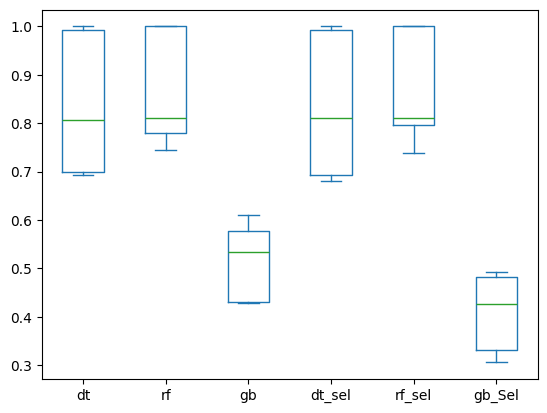

In [28]:
F1_2=F1[ ['dt', 'rf', 'gb', 'dt_sel', 'rf_sel', 'gb_Sel']]
F1_2.plot(kind='box') ### gráfico para modelos sel y todas las variables

F1.mean() ### medias de mape

#Evaluación_accuracy

In [29]:
accuracy_full=fn.medir_modelos(modelos,"accuracy",X,y,5) ## base con todas las variables
accuracy_varsel=fn.medir_modelos(modelos,"accuracy",X2,y,5) ### base con variables seleccionadas


accuracy=pd.concat([accuracy_full,accuracy_varsel],axis=1)
accuracy.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
accuracy

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.862812,0.997732,1.000000,0.910431,0.856009,0.997732,1.000000,0.897959
1,0.863946,0.930839,0.946712,0.891156,0.853741,0.928571,0.941043,0.876417
2,0.862812,0.998866,1.000000,0.917234,0.854875,1.000000,1.000000,0.899093
3,0.863946,0.930839,0.946712,0.892290,0.856009,0.930839,0.942177,0.876417
4,0.844671,0.929705,0.930839,0.887755,0.852608,0.930839,0.930839,0.875283


rl        0.859637
dt        0.957596
rf        0.964853
gb        0.899773
rl_Sel    0.854649
dt_sel    0.957596
rf_sel    0.962812
gb_Sel    0.885034
dtype: float64

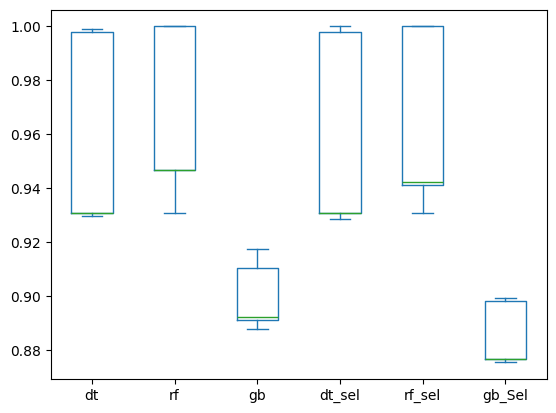

In [30]:
accuracy_2=accuracy[ ['dt', 'rf', 'gb', 'dt_sel', 'rf_sel', 'gb_Sel']]
accuracy_2.plot(kind='box') ### gráfico para modelos sel y todas las variables
accuracy.mean() ### medias de mape

Comparación de metricas (F1 vs Accuracy) de acuerdo al modelo

In [31]:
# Tabla con promedio de métricas con todas las variables
average_metrics_full = pd.DataFrame({
    'Model': ['reg_lineal', 'decision_tree', 'random_forest', 'gradient_boosting'],
    'F1_Average': [F1['rl'].mean(), F1['dt'].mean(), F1['rf'].mean(), F1['gb'].mean()],
    'Accuracy_Average': [accuracy['rl'].mean(), accuracy['dt'].mean(), accuracy['rf'].mean(), accuracy['gb'].mean()]
})
average_metrics_full

,Model,F1_Average,Accuracy_Average
0,reg_lineal,0.219670,0.859637
1,decision_tree,0.838393,0.957596
2,random_forest,0.866655,0.964853
3,gradient_boosting,0.516306,0.899773


In [32]:
# Tabla con promedio de métricas segun Variables Seleccionadas
average_metrics_varsel = pd.DataFrame({
    'Model': ['reg_lineal_sel', 'decision_tree_sel', 'random_forest_sel', 'gradient_boosting_sel'],
    'F1_Average': [F1['rl_Sel'].mean(), F1['dt_sel'].mean(), F1['rf_sel'].mean(), F1['gb_Sel'].mean()],
    'Accuracy_Average': [accuracy['rl_Sel'].mean(), accuracy['dt_sel'].mean(), accuracy['rf_sel'].mean(), accuracy['gb_Sel'].mean()]
})
average_metrics_varsel

,Model,F1_Average,Accuracy_Average
0,reg_lineal_sel,0.041839,0.854649
1,decision_tree_sel,0.835177,0.957596
2,random_forest_sel,0.868826,0.962812
3,gradient_boosting_sel,0.407658,0.885034


## Respuesta de mejores modelos según métricas

En la grafica boxplot y las tablas de las metricas, se visualiza los algoritmos con mejor rendimiento como el algoritmo arboles de decision y bosques aleatorios, se puede notar una mejora cuando se aplican a las variables seleccionadas mediante la funcion de selección de variables.

Por lo anterior se procede a realizar el tuneo de hiperparametros para estos dos modelo los cuales tuvieron mejor desempeño

# Tuneo de hiperparametros

## Arboles de decisión

In [33]:
param_grid = [{'max_depth': [3, 5, 7, 9, 11, None], 
               'min_samples_split': [2, 5, 10, 20], 
               'min_samples_leaf': [1, 5, 10, 20]}]

tun_rtree = RandomizedSearchCV(m_rtree, param_distributions=param_grid, n_iter=10, scoring="accuracy")
tun_rtree.fit(X2, y)

pd.set_option('display.max_colwidth', 100)
resultados = tun_rtree.cv_results_
print(tun_rtree.best_params_)
pd_resultados = pd.DataFrame(resultados)
display(pd_resultados[["params", "mean_test_score"]])
rtree_final = tun_rtree.best_estimator_

{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}


,params,mean_test_score
0,"{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 7}",0.869841
1,"{'min_samples_split': 2, 'min_samples_leaf': 20, 'max_depth': 5}",0.862358
2,"{'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': 7}",0.880726
3,"{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 5}",0.862358
4,"{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}",0.930612
5,"{'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 3}",0.854875
6,"{'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 7}",0.879365
7,"{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}",0.886848
8,"{'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': None}",0.879592
9,"{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}",0.905442


## Bosques Aleatorios

In [34]:
param_grid = [{'n_estimators': [3, 500, 100], 'max_features': [5,20],
               'min_samples_split': [100, 20, 5]}]

tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=10,scoring="accuracy")
tun_rf.fit(X2,y)


pd.set_option('display.max_colwidth', 100)
resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)
display(pd_resultados[["params", "mean_test_score"]])
rf_final=tun_rf.best_estimator_

,params,mean_test_score
0,"{'n_estimators': 3, 'min_samples_split': 20, 'max_features': 20}",0.911338
1,"{'n_estimators': 3, 'min_samples_split': 20, 'max_features': 5}",0.896599
2,"{'n_estimators': 500, 'min_samples_split': 100, 'max_features': 5}",0.865079
3,"{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 20}",0.962132
4,"{'n_estimators': 500, 'min_samples_split': 20, 'max_features': 5}",0.913832
5,"{'n_estimators': 100, 'min_samples_split': 20, 'max_features': 5}",0.916553
6,"{'n_estimators': 100, 'min_samples_split': 20, 'max_features': 20}",0.921995
7,"{'n_estimators': 500, 'min_samples_split': 5, 'max_features': 5}",0.961224
8,"{'n_estimators': 3, 'min_samples_split': 5, 'max_features': 5}",0.957823
9,"{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 5}",0.962132


# Exportar y guardar objetos de python

In [35]:
joblib.dump(rf_final, "salidas\\rf_final.pkl")
joblib.dump(m_lreg, "salidas\\m_lreg.pkl")
joblib.dump(rtree_final, "salidas\\rtree_final.pkl")
joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### Las variables que se convierten a dummies
joblib.dump(var_names, "salidas\\var_names.pkl")  ### las variables con que se entrena modelo
joblib.dump(scaler, "salidas\\scaler.pkl")


### funcion para cargar objeto guardado ###
rf_final = joblib.load("salidas\\rf_final.pkl")
rtree_final = joblib.load("salidas\\rtree_final.pkl")
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

list_dummies=joblib.load("salidas\\list_dummies.pkl")
var_names=joblib.load("salidas\\var_names.pkl")
scaler=joblib.load("salidas\\scaler.pkl") 

print(hasattr(rf_final, 'fit'))  # Si es True, rf_final tiene un método fit
print(hasattr(rtree_final, 'fit'))  # Si es True, rtree_final tiene un método fit

True
True


# Evaluación

Metrica para el entrenamiento y evaluación para mirar sobre ajuste

In [36]:
eval=cross_validate(rf_final,X2,y,cv=5,scoring="accuracy",return_train_score=True)
eval2=cross_validate(rtree_final,X2,y,cv=5,scoring="accuracy",return_train_score=True)

## **Resultados para  RF y DTREE**

In [37]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para RF
train_rf=pd.DataFrame(eval['train_score'])
test_rf=pd.DataFrame(eval['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']

#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para RTree
train_rtree=pd.DataFrame(eval2['train_score'])
test_rtree=pd.DataFrame(eval2['test_score'])
train_test_rtree=pd.concat([train_rtree, test_rtree],axis=1)
train_test_rtree.columns=['train_score','test_score']

In [38]:
print("train_test_rf:")
print(train_test_rf)
print("\ntrain_test_rtree:")
print(train_test_rtree)

train_test_rf:
   train_score  test_score
0     0.982710    1.000000
1     0.982710    0.942177
2     0.982426    1.000000
3     0.982710    0.939909
4     1.000000    0.929705

train_test_rtree:
   train_score  test_score
0     0.958900    0.962585
1     0.961451    0.911565
2     0.958050    0.968254
3     0.957766    0.917234
4     0.973356    0.895692


In [39]:
print("train score rf : ", train_test_rf["train_score"].mean())
print("\ntest score rf: ", train_test_rf["test_score"].mean())
print("\ntrain score rtree : ", train_test_rtree["train_score"].mean())
print("\ntest score rtree: ", train_test_rtree["test_score"].mean())

train score rf :  0.986111111111111

test score rf:  0.962358276643991

train score rtree :  0.9619047619047618

test score rtree:  0.9310657596371881


## **Importancia de variables**

### Random Forest

In [40]:
pd.set_option('display.max_rows', 100)
importancia1=pd.DataFrame(rf_final.feature_names_in_)
importancia2=pd.DataFrame(rf_final.feature_importances_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]
importancia.sort_values('peso')
importancia.sort_values(by=["peso"], ascending=False)

,variable,peso
4,MonthlyIncome,0.204788
0,Age,0.142192
7,TotalWorkingYears,0.139038
1,DistanceFromHome,0.111711
6,PercentSalaryHike,0.093402
5,NumCompaniesWorked,0.075981
2,EnvironmentSatisfaction,0.068170
8,YearsSinceLastPromotion,0.057556
9,YearsWithCurrManager,0.056141
3,JobSatisfaction,0.051021


### Decision Tree

In [41]:
importancia1=pd.DataFrame( rtree_final.feature_names_in_)
importancia2=pd.DataFrame(rtree_final.feature_importances_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]
importancia.sort_values('peso')
importancia.sort_values(by=["peso"], ascending=False)

,variable,peso
4,MonthlyIncome,0.218329
1,DistanceFromHome,0.157014
7,TotalWorkingYears,0.155417
0,Age,0.142080
5,NumCompaniesWorked,0.071650
6,PercentSalaryHike,0.060944
3,JobSatisfaction,0.057846
9,YearsWithCurrManager,0.056348
2,EnvironmentSatisfaction,0.046521
8,YearsSinceLastPromotion,0.033851


Despues del tuneo de hiperparametros y la evaluacion el modelo que mejor desempeño mantiene  es el RandomForest el cual usaremos finalmente en el despliegue del proyecto.

# Matriz de confusión (RandomForest)

[[742  15]
 [ 24 101]]


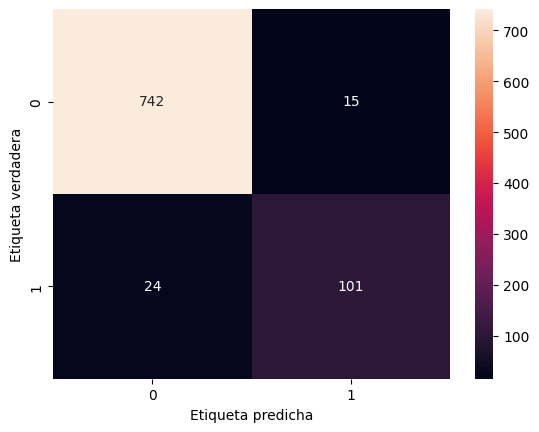

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')

plt.show()

Finalmente realizamos la matriz de confucion con el algoritmo de RandomForest para confirmar su desempeño y rendimiento frente a los datos.